In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd

from IPython.display import display, clear_output, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 80%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 80%; }
</style>
"""))

In [2]:
#load data
dataset_path = r'C:\Users\admin\Desktop\PanithanS\Wafer_defect\Wafer_Map_Datasets.npz'
data = np.load(dataset_path)
print(data.files)

['arr_0', 'arr_1']


(38015, 52, 52)
(38015, 8)
[1 0 1 0 0 0 1 0]


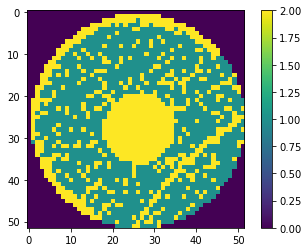

In [3]:
#Vis
num = 100
train = data["arr_0"]
print(np.shape(train))

image = train[num]
plt.imshow(image)
plt.colorbar()

label = data["arr_1"]
print(np.shape(label))
print(label[num])

In [5]:
x_train, x_test, y_train, y_test = train_test_split(train, label, test_size = 0.2)

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

(_, a, b, c) = np.shape(x_train) # We'll resize input images to this size
image_size = a

In [6]:
print(np.shape(x_train))
print(np.shape(y_test))

(30412, 52, 52, 1)
(7603, 8)


In [7]:
# Convert class vectors to right format
y_train = tf.convert_to_tensor(np.array(y_train))
y_test = tf.convert_to_tensor(np.array(y_test))

In [8]:
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.Normalization(),
        #layers.Resizing(image_size, image_size),
        #layers.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.02),
        tf.keras.layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [9]:
(_, a, b, c) = np.shape(x_train) # We'll resize input images to this size
input_shape = (a, b, c)

image_size = a
patch_size = 13  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 128
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 32
mlp_head_units = [1536, 1024]  # Size of the dense layers of the final classifier

In [10]:
input_shape = (a, b, c)
label_size = 8
patch_size = 13  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2

projection_dim = 96
num_heads = 4
transformer_units = [projection_dim * 2, projection_dim,]  # Size of the transformer layers
transformer_layers = 16
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

def mlp(x, hidden_units, dropout_rate):
    
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

class Patches(layers.Layer):
    
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 52 X 52
Patch size: 13 X 13
Patches per image: 16
Elements per patch: 169
Num patch: 16


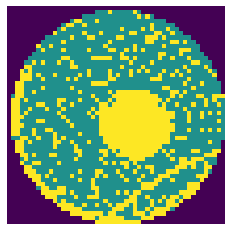

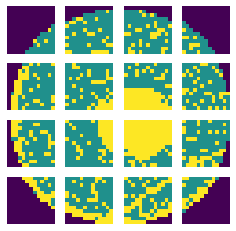

In [11]:
# plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")
print(f"Num patch:", num_patches)

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size))
    plt.imshow(patch_img.numpy())
    plt.clim(0,2)
    plt.axis("off")

# Model

In [12]:
class PatchEncoder(layers.Layer):
    
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        
        return encoded
    
def create_vit_classifier():
    
    inputs = layers.Input(shape=(52,52,1))
    
    # Augment data.
    augmented = inputs #data_augmentation(inputs)
    
    # Create patches.
    patches = Patches(patch_size)(augmented)
    
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    
    #print(np.shape(encoded_patches))

    # Create multiple layers of the Transformer block.
    
    for _ in range(transformer_layers):
        
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        
        #print(np.shape(attention_output))
        
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        
        
        
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])
    
    print('encoded_patches:', np.shape(encoded_patches))
    
    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.2)(representation)
    
    print('representation:', np.shape(representation))
    
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    
    print('features:', np.shape(features))
    
    # Classify outputs.
    #features = layers.Dense(label_size*2, kernel_initializer='he_uniform', activation='relu')(features)
    logits = layers.Dense(label_size, activation='sigmoid')(features)
    
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    
    #print(model.summary())
    
    return model

# To pick correct 'activation function' according to the output label
- https://towardsdatascience.com/deep-learning-which-loss-and-activation-functions-should-i-use-ac02f1c56aa8
- Dataset: https://www.kaggle.com/datasets/co1d7era/mixedtype-wafer-defect-datasets

##### tf2.4.0: https://docs.w3cub.com/tensorflow~2.4/keras/optimizers/adamax

In [17]:
def run_experiment(model):
    
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)
    
    opt = tf.keras.optimizers.Adam(lr_schedule)
    
#     model.compile(optimizer=opt,
#                   loss=keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.SUM), 
#                   metrics=keras.metrics.BinaryAccuracy(name="accuracy"))

    model.compile(optimizer=opt,
                  loss='binary_crossentropy', 
                  metrics=keras.metrics.BinaryAccuracy(name="accuracy"))

    checkpoint_filepath = "./tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )
    
    batch_size = 512
    num_epochs = 20
    
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    #print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

model_vit = create_vit_classifier()
history = run_experiment(model_vit)

encoded_patches: (None, 16, 96)
representation: (None, 1536)
features: (None, 1024)
Epoch 1/20
54/54 [==============================] - 329s 6s/step - loss: 0.7210 - accuracy: 0.6595 - val_loss: 0.5005 - val_accuracy: 0.7071
Epoch 2/20
54/54 [==============================] - 313s 6s/step - loss: 0.5113 - accuracy: 0.7068 - val_loss: 0.4442 - val_accuracy: 0.7355
Epoch 3/20
54/54 [==============================] - 305s 6s/step - loss: 0.4893 - accuracy: 0.7191 - val_loss: 0.3672 - val_accuracy: 0.7991
Epoch 4/20
54/54 [==============================] - 324s 6s/step - loss: 0.3444 - accuracy: 0.8155 - val_loss: 0.3020 - val_accuracy: 0.8508
Epoch 5/20
54/54 [==============================] - 327s 6s/step - loss: 0.2623 - accuracy: 0.8739 - val_loss: 0.1557 - val_accuracy: 0.9366
Epoch 6/20
54/54 [==============================] - 333s 6s/step - loss: 0.1753 - accuracy: 0.9265 - val_loss: 0.1126 - val_accuracy: 0.9581
Epoch 7/20
54/54 [==============================] - 345s 6s/step - los

In [18]:
model_vit.evaluate(x_test, y_test)

238/238 [==============================] - 24s 99ms/step - loss: 0.0424 - accuracy: 0.9856: 20s - loss: 0. - ETA: 1 - ETA: 1s - loss: 0


[0.042413532733917236, 0.9856142401695251]

In [19]:
prediction = model_vit.predict(x_test, verbose=1)

238/238 [==============================] - 25s 98ms/step


In [38]:
_, accuracy = model_vit.evaluate(x_test, y_test)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

238/238 [==============================] - 24s 101ms/step - loss: 0.0424 - accuracy: 0.9856 21s - loss: 0.0465  - ETA: 20s - loss: 0.0416 - a - ETA: 18s - - ETA: 15s - lo - ETA: 12s - loss: 0.0410 - accura - ETA: 11s - loss: 0.0399 - accuracy: - ETA: 10s - loss: 0.0402 - accuracy:  - ETA: 10s - loss: 0. - ETA: 8s - loss: 0.0405 - accu - ETA: 8s - loss: 0.0407 - accuracy: 0.98 - ETA: 8s - loss: 0.0406 - accuracy: 0. - - ETA: 1s - loss: 0.0423 - accu - ETA: 0s - loss: 0.042
Test accuracy: 98.56%


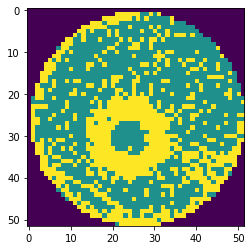

Model output: [3.0047627e-06 9.9999833e-01 9.9998516e-01 2.3307650e-05 9.9990726e-01
 7.1924046e-07 9.9881709e-01 1.8978037e-06]
Predictions : [0 1 1 0 1 0 1 0]
Ground-truth: [0 1 1 0 1 0 1 0]


In [37]:
pred_img_num = 900
image = np.squeeze(x_test[pred_img_num,:,:,0])
plt.imshow(image)
plt.show()

print("Model output:", (prediction[pred_img_num,:]))
print("Predictions : [" + " ".join(["{:.0f}".format(val) for val in prediction[pred_img_num]]) + "]")
print("Ground-truth:", np.array(y_test[pred_img_num,:]))

In [44]:
# Save the weights using the `checkpoint_path` format
path_ = r"C:\Users\admin\Desktop\PanithanS\Wafer_defect"
model_vit.save_weights(path_+'\\'+'model_vit_01')

# Load model

In [45]:
model_vit_temp = create_vit_classifier()
model_vit_temp.load_weights(path_+'\\'+'model_vit_01')

encoded_patches: (None, 16, 96)
representation: (None, 1536)
features: (None, 1024)


238/238 [==============================] - 25s 102ms/step


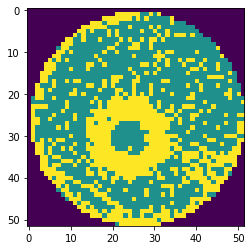

Model output: [3.0047627e-06 9.9999833e-01 9.9998516e-01 2.3307650e-05 9.9990726e-01
 7.1924046e-07 9.9881709e-01 1.8978037e-06]
Predictions : [0 1 1 0 1 0 1 0]
Ground-truth: [0 1 1 0 1 0 1 0]


In [47]:
prediction_temp = model_vit_temp.predict(x_test, verbose=1)

pred_img_num = 900
image = np.squeeze(x_test[pred_img_num,:,:,0])
plt.imshow(image)
plt.show()

print("Model output:", (prediction[pred_img_num,:]))
print("Predictions : [" + " ".join(["{:.0f}".format(val) for val in prediction[pred_img_num]]) + "]")
print("Ground-truth:", np.array(y_test[pred_img_num,:]))